In [1]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from transformers import  BertTokenizer, TFBertModel
import implicit
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf
import pydot
import graphviz


In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])

In [3]:
ratingsnew = ratings_.head(10000)
# ratingsnew.index = np.arange(len(ratingsnew))
ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1000))


                    user_id             business_id stars  \
0    mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   3.0   
1    OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   5.0   
2    8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   3.0   
3    _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   5.0   
4    bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   4.0   
..                      ...                     ...   ...   
995  syyKcKPFILDysHWmtka-aA  1_hDCN3iioFR3XnUr32ZtA   5.0   
996  _lgLNzpzf3qmbwySBakxEw  5RzJ2bjU8bLSaN5SuiUpYA   4.0   
997  Sh_vUlHHY2Kuj14eF8NYZQ  s1PNBO9o5jIgNd5YWUDLXQ   5.0   
998  YwMD-AVT67fmYRGxnlRSPA  alUk6OwNhofyc90NDMDY-Q   5.0   
999  WKe2b_EeLBnZ3lZV5WKYGQ  -Or44IdY51Ukd618kikmtA   4.0   

                                                  text  
0    [[CLS], If, you, decide, to, eat, here, ,, jus...  
1    [[CLS], I, ', ve, taken, a, lot, of, spin, cla...  
2    [[CLS], Family, diner, ., Had, the, b, ##uff, ...  
3    [[CLS], Wow, !, Yu, ##mmy, ,, diff

C:\Users\apran\AppData\Local\Temp\ipykernel_15480\1543095828.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingsnew['text'] = ratingsnew['text'].astype(str)


In [4]:
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes

C:\Users\apran\AppData\Local\Temp\ipykernel_15480\1655519412.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
C:\Users\apran\AppData\Local\Temp\ipykernel_15480\1655519412.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [5]:

sparse_item_user = sparse.csr_matrix((df_features['stars'].astype('float'), (df_features['user_id'], df_features['business_id'])))
sparse_user_item = sparse.csr_matrix((df_features['stars'].astype('float'),  (df_features['business_id'],df_features['user_id'])))

In [6]:
modelRec = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)


alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')


modelRec.fit(data_conf)

c:\Users\apran\anaconda3\envs\nlp\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)
df_features.head()

C:\Users\apran\AppData\Local\Temp\ipykernel_15480\3483575756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["labels"] = df_features.apply(lambda row: modelRec.user_factors[row['user_id']],axis=1)


,user_id,business_id,stars,text,labels
0,2046,3507,4.0,[CLS] I was unexpectedly surprised with how mu...,"[-1.812676, 1.258486, 0.9226284, 0.33656356, 1..."
1,3928,3594,4.0,"[CLS] It was a wait , but worth it I enjoy eve...","[0.41869983, 1.2699835, 0.40610248, 0.12931244..."
2,4968,3538,1.0,[CLS] This place has gone downhill . Extreme #...,"[-5.311632e-12, -1.9197179e-11, -1.3432616e-11..."
3,7980,3012,5.0,"[CLS] Excellent service , has air conditioning...","[1.2758422, -1.0850755, -0.91571385, 1.9398854..."
4,9004,1527,4.0,"[CLS] Came here for Sunday br ##unch , of cour...","[0.8829429, 0.4846862, 0.024822649, 0.59127104..."


In [8]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)
y_train = tf.convert_to_tensor(
    train_df["labels"].tolist(), dtype=float
)

y_test = tf.convert_to_tensor(
    test_df["labels"].tolist(), dtype=float
)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('roberta-base')

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at roberta-base were not used when initializing TFBertModel: ['roberta', 'lm_head']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=512,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [11]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [13]:
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'linear')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True


In [14]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss = MeanSquaredError()
metric = MeanSquaredError()
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [MeanSquaredError()])

In [15]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2
223/223 [==============================] - 895s 4s/step - loss: 1.1974 - mean_squared_error: 1.1978 - val_loss: 1.1138 - val_mean_squared_error: 1.1138
Epoch 2/2
223/223 [==============================] - 1049s 5s/step - loss: 1.1267 - mean_squared_error: 1.1263 - val_loss: 1.1254 - val_mean_squared_error: 1.1253


In [16]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]

21/63 [=========>....................] - ETA: 3:38

KeyboardInterrupt: 

In [19]:
import pydot
import pydotplus
import graphviz

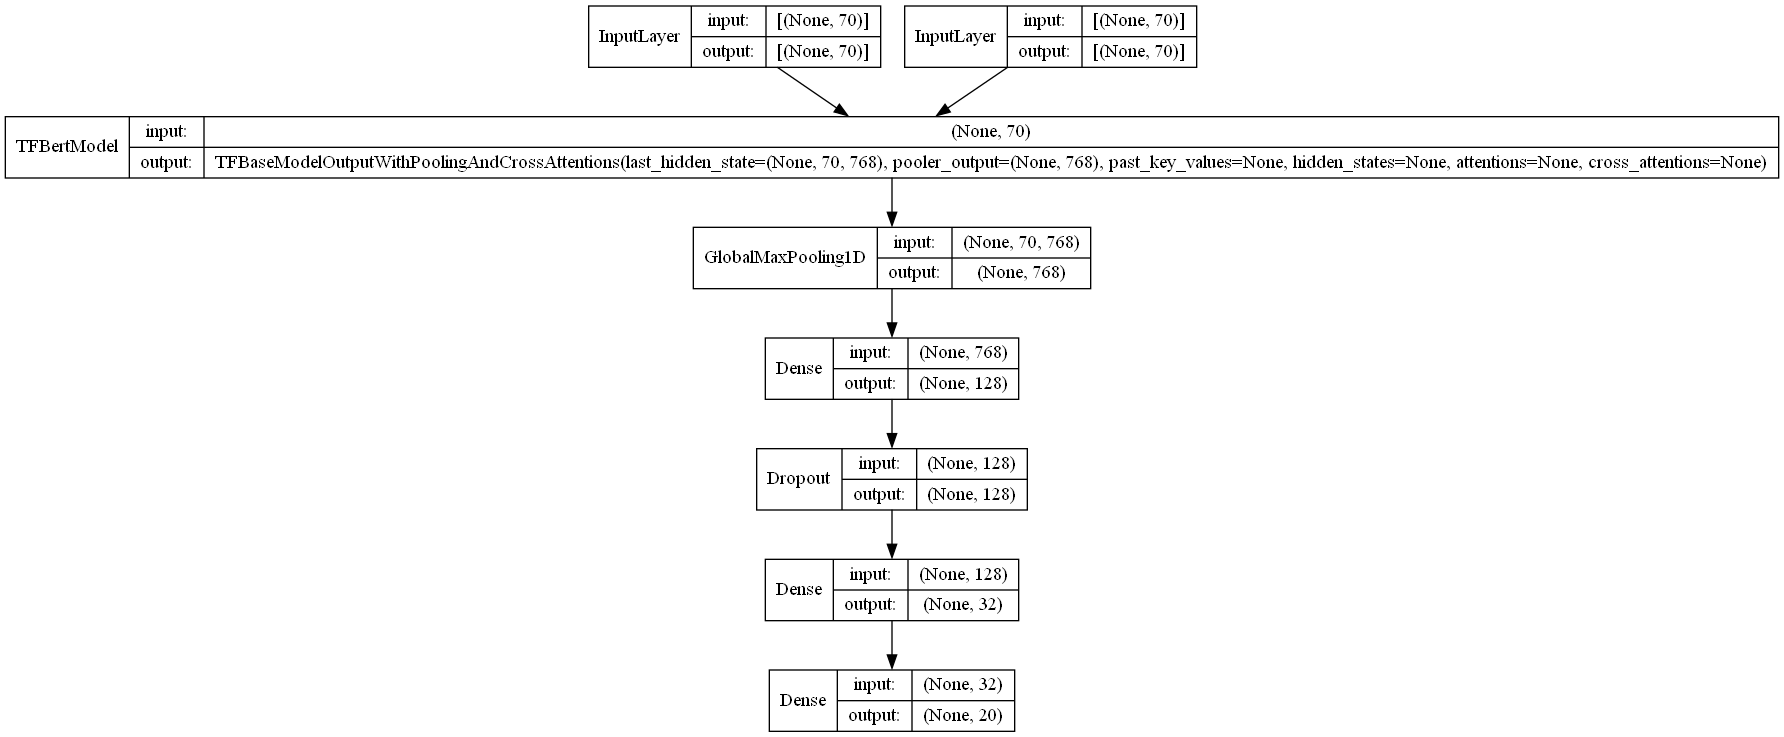

In [23]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

tf.keras.utils.plot_model(model, to_file='model_test.png',expand_nested=True, show_shapes=True, show_layer_names=True)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            